In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeRegressor
# scikit learn baggingRegressor, baggingClassifier doens't have max depth

In [23]:
class BaggedTreeRegressor:
    def __init__(self, n_estimators, max_depth=None):
        self.B = n_estimators
        self.max_depth = max_depth

    def fit(self, X, Y):
        N = len(X)
        self.models = []
        for b in range(self.B):
            idx = np.random.choice(N, size=N, replace=True)
            Xb = X[idx]
            Yb = Y[idx]

            model = DecisionTreeRegressor(max_depth=self.max_depth)
            model.fit(Xb, Yb)
            self.models.append(model)

    def predict(self, X):
        predictions = np.zeros(len(X))
        for model in self.models:
            predictions += model.predict(X)
        return predictions / self.B

    def score(self, X, Y):
        d1 = Y - self.predict(X)
        d2 = Y - Y.mean()
        return 1 - d1.dot(d1) / d2.dot(d2)

In [24]:
class BaggedTreeClassifier:
    def __init__(self, n_estimators, max_depth=None):
        self.B = n_estimators
        self.max_depth = max_depth

    def fit(self, X, Y):
        N = len(X)
        self.models = []
        for b in range(self.B):
            idx = np.random.choice(N, size=N, replace=True)
            Xb = X[idx]
            Yb = Y[idx]

            model = DecisionTreeClassifier(max_depth=self.max_depth)
            model.fit(Xb, Yb)
            self.models.append(model)

    def predict(self, X):
        # no need to keep a dictionary since we are doing binary classification
        predictions = np.zeros(len(X))
        for model in self.models:
            predictions += model.predict(X)
        return np.round(predictions / self.B)

    def score(self, X, Y):
        P = self.predict(X)
        return np.mean(Y == P)

# 1. Basic Data

### 1. Make Data

In [25]:
N = 15
D = 100
X = (np.random.random((N, D)) - 0.5) * 10
Y = X.sum(axis=1)**2 + 0.5 * np.random.randn(N)

In [26]:
Ntrain = int(N / 2)
Xtrain = X[:Ntrain]
Ytrain = Y[:Ntrain]
Xtest = X[Ntrain:]
Ytest = Y[Ntrain:]

### 2. Test

In [27]:
T = 300
test_error_rf = np.empty(T)
test_error_bag = np.empty(T)

for num_trees in range(T):
    if num_trees == 0:
        test_error_rf[num_trees] = None
        test_error_bag[num_trees] = None
        
    else:
        rf = RandomForestRegressor(n_estimators=num_trees)
        rf.fit(Xtrain, Ytrain)
        test_error_rf[num_trees] = rf.score(Xtest, Ytest)
        
        bg = BaggedTreeRegressor(n_estimators=num_trees)
        bg.fit(Xtrain, Ytrain)
        test_error_bag[num_trees] = bg.score(Xtest, Ytest)
        
    if num_trees % 10 == 0:
        print("num trees: ", num_trees)

num trees:  0
num trees:  10
num trees:  20
num trees:  30
num trees:  40
num trees:  50
num trees:  60
num trees:  70
num trees:  80
num trees:  90
num trees:  100
num trees:  110
num trees:  120
num trees:  130
num trees:  140
num trees:  150
num trees:  160
num trees:  170
num trees:  180
num trees:  190
num trees:  200
num trees:  210
num trees:  220
num trees:  230
num trees:  240
num trees:  250
num trees:  260
num trees:  270
num trees:  280
num trees:  290


### Show result

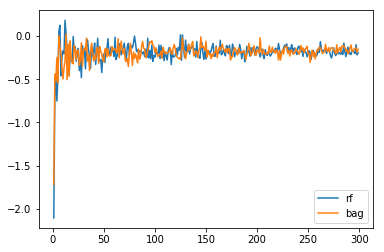

In [28]:
plt.plot(test_error_rf, label='rf')
plt.plot(test_error_bag, label='bag')
plt.legend()
plt.show()

# 2. House Data

In [55]:
class DataTransformer:
    def fit(self, df):
        self.scalers = {}
        for col in NUMERICAL_COLS:
            scaler = StandardScaler()
            scaler.fit(df[col].as_matrix().reshape(-1, 1))
            self.scalers[col] = scaler
            
    def transform(self, df):
        N, _   = df.shape
        D = len(NUMERICAL_COLS) + len(NO_TRANSFORM)
        X = np.zeros((N,D))
        i = 0
        
        for col, scaler in self.scalers.items():
            X[:, i] = scaler.transform(df[col].as_matrix().reshape(-1, 1)).flatten()
            i += 1
        
        for col in NO_TRANSFORM:
            X[:, i] = df[col]
            i += 1
        return X
    
    def fit_transform(self, df):
        self.fit(df)
        return self.transform(df)

### Get Data

In [56]:
def get_data():
    # regex allows arbitrary number of spaces in seperator
    df = pd.read_csv('./housing.data.txt', header=None, sep=r'\s*', engine='python')
    df.columns = [
        'crim', 'zn', 'nonretail', 'river', 'nox', 'rooms',
        'age', 'dis', 'rad', 'tax', 'ptratio', 'b', 'lstat', 'medv'
    ]
    
    #transformer
    transformer = DataTransformer()
    
    #shuffle the data
    N = len(df)
    train_idx = np.random.choice(N, size=int(0.7*N), replace=False)
    test_idx = [i for i in range(N) if i not in train_idx]
    df_train = df.loc[train_idx]
    df_test = df.loc[test_idx]
    
    Xtrain = transformer.fit_transform(df_train)
    Ytrain = np.log(df_train['medv'].as_matrix())
    Xtest = transformer.transform(df_test)
    Ytest = np.log(df_test['medv'].as_matrix())
    return Xtrain, Ytrain, Xtest, Ytest

In [57]:
Xtrain, Ytrain, Xtest, Ytest = get_data()

C:\Users\sailyourlife\Anaconda3\lib\site-packages\pandas\io\parsers.py:2138: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
C:\Users\sailyourlife\Anaconda3\lib\site-packages\pandas\io\parsers.py:2140: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
C:\Users\sailyourlife\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### Test

In [58]:
T = 300
test_error_rf = np.empty(T)
test_error_bag = np.empty(T)

for num_trees in range(T):
    if num_trees == 0:
        test_error_rf[num_trees] = None
        test_error_bag[num_trees] = None
        
    else:
        rf = RandomForestRegressor(n_estimators=num_trees)
        rf.fit(Xtrain, Ytrain)
        test_error_rf[num_trees] = rf.score(Xtest, Ytest)
        
        bg = BaggedTreeRegressor(n_estimators=num_trees)
        bg.fit(Xtrain, Ytrain)
        test_error_bag[num_trees] = bg.score(Xtest, Ytest)
        
    if num_trees % 10 == 0:
        print("num trees: ", num_trees)

num trees:  0
num trees:  10
num trees:  20
num trees:  30
num trees:  40
num trees:  50
num trees:  60
num trees:  70
num trees:  80
num trees:  90
num trees:  100
num trees:  110
num trees:  120
num trees:  130
num trees:  140
num trees:  150
num trees:  160
num trees:  170
num trees:  180
num trees:  190
num trees:  200
num trees:  210
num trees:  220
num trees:  230
num trees:  240
num trees:  250
num trees:  260
num trees:  270
num trees:  280
num trees:  290


### Show Result

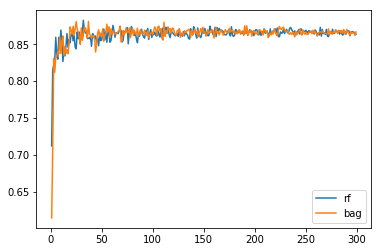

In [59]:
plt.plot(test_error_rf, label='rf')
plt.plot(test_error_bag, label='bag')
plt.legend()
plt.show()

# 3. Mushroom

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [66]:
NUMERICAL_COLS = ()
CATEGORICAL_COLS = np.arange(22) + 1 # 1..22 inclusive

In [67]:
class DataTransformer:
    def fit(self, df):
        self.labelEncoders = {}
        self.scalers = {}
        
        # numerical
        for col in NUMERICAL_COLS:
            scaler = StandardScaler()
            scaler.fit(df[col].reshape(-1, 1))
            self.scalers[col] = scaler
            
        # categorical
        for col in CATEGORICAL_COLS:
            encoder = LabelEncoder()
            
            # in case the train set does not have 'missing value but test set does
            values = df[col].tolist()
            values.append('missing')
            encoder.fit(values)
            self.labelEncoders[col] = encoder
            
        # find dimensionality
        self.D = len(NUMERICAL_COLS)
        for col, encoder in self.labelEncoders.items():
            self.D += len(encoder.classes_)
        print("dimensionality: ", self.D)
        
    def transform(self, df):
        N, _ = df.shape
        X = np.zeros((N, self.D))
        i = 0
        
        # put data in X
        for col, scaler in self.scalers.items():
            X[:,i] = scaler.transform(df[col].as_matrix().reshape(-1, 1)).flatten()
            i += 1
        
        for col, encoder in self.labelEncoders.items():
            K = len(encoder.classes_)
            X[np.arange(N), encoder.transform(df[col]) + i] = 1
            i += K
        return X
    
    def fit_transform(self, df):
        self.fit(df)
        return self.transform(df)

In [71]:
def replace_missing(df):
    # standard method of replacement for numerical columns is median
    
    for col in NUMERICAL_COLS:
        if np.any(df[col].isnull()):
            # median replacing
            med = np.median(df[col][df[col].notnull()])
            df.loc[df[col].isnull(), col] = med
            
    # set a special value = 'missing'
    for col in CATEGORICAL_COLS:
        if np.any(df[col].isnull()):
            print(col)
            df.loc[df[col].isnull(), col] = 'missing'

### Get Data

In [72]:
def get_data():
    df = pd.read_csv('./agaricus-lepiota.data.txt', header=None)
       
    # replace label column: e/p --> 0/1
    df[0] = df.apply(lambda row: 0 if row[0] =='e' else 1, axis=1)
    
    # missing data
    replace_missing(df)

    # transform data
    transformer = DataTransformer()
    
    X = transformer.fit_transform(df)
    Y = df[0].as_matrix()
    return X, Y

In [75]:
X, Y = get_data()
Ntrain = int(0.8*len(X))
Xtrain, Ytrain = X[:Ntrain], Y[:Ntrain]
Xtest, Ytest = X[Ntrain:], Y[Ntrain:]

dimensionality:  139


### Test

In [76]:
T = 300
test_error_rf = np.empty(T)
test_error_bag = np.empty(T)

for num_trees in range(T):
    if num_trees == 0:
        test_error_rf[num_trees] = None
        test_error_bag[num_trees] = None
        
    else:
        rf = RandomForestClassifier(n_estimators=num_trees)
        rf.fit(Xtrain, Ytrain)
        test_error_rf[num_trees] = rf.score(Xtest, Ytest)
        
        bg = BaggedTreeClassifier(n_estimators=num_trees)
        bg.fit(Xtrain, Ytrain)
        test_error_bag[num_trees] = bg.score(Xtest, Ytest)
        
    if num_trees % 10 == 0:
        print("num trees: ", num_trees)

num trees:  0
num trees:  10
num trees:  20
num trees:  30
num trees:  40
num trees:  50
num trees:  60
num trees:  70
num trees:  80
num trees:  90
num trees:  100
num trees:  110
num trees:  120
num trees:  130
num trees:  140
num trees:  150
num trees:  160
num trees:  170
num trees:  180
num trees:  190
num trees:  200
num trees:  210
num trees:  220
num trees:  230
num trees:  240
num trees:  250
num trees:  260
num trees:  270
num trees:  280
num trees:  290


### Show Result

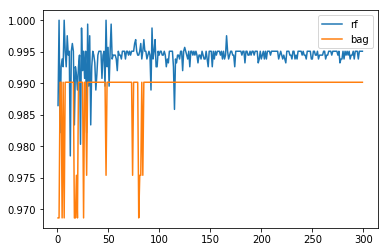

In [77]:
plt.plot(test_error_rf, label='rf')
plt.plot(test_error_bag, label='bag')
plt.legend()
plt.show()